<a href="https://colab.research.google.com/github/Prathamesh-Chavan-98/SIH-colab-code/blob/main/defogging_and_detection_of_rainy_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install ultralytics==8.0.196

In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.4/107.7 GB disk)


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
import io
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO

In [ ]:
%cd {HOME}

/content


In [ ]:
model = YOLO("yolov8l.pt")

In [ ]:
# Function for Dark Channel Prior (DCP) defogging
def apply_dcp(image, window_size=15):
    min_channel = cv2.erode(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), np.ones((window_size, window_size), np.uint8))
    num_pixels = int(image.shape[0] * image.shape[1] * 0.001)
    dark_channel_flat = min_channel.reshape(-1)
    indices = dark_channel_flat.argsort()[-num_pixels:]
    atmospheric_light = np.max(image.reshape(-1, 3)[indices], axis=0)
    omega = 0.95
    atmospheric_light = np.array(atmospheric_light, dtype=np.float64)
    transmission = 1 - omega * min_channel / atmospheric_light.max()
    epsilon = 0.001
    scene_radiance = np.zeros_like(image, dtype=np.float64)
    for i in range(3):
        scene_radiance[:, :, i] = ((image[:, :, i].astype(np.float64) - atmospheric_light[i]) / np.maximum(transmission, epsilon)) + atmospheric_light[i]
    scene_radiance = np.uint8(np.clip(scene_radiance, 0, 255))
    return scene_radiance

def detect_objects(image):
     results = model.predict(source=image, stream=True,save=True)
     for r in results:
        boxes = r.boxes
        masks = r.masks
        probs = r.probs
     return results

# Function to apply Histogram Equalization
def apply_hist_eq(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    lab_planes_new = [clahe.apply(plane) for plane in lab_planes]
    lab = cv2.merge(lab_planes_new)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def take_photo(quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')

    display(js)
    try:
        while True:
            # Capture a frame
            # data = eval_js('takePhoto({})'.format(quality))
            # binary = b64decode(data.split(',')[1])

            # Convert the image data to a NumPy array
            # img_array = np.frombuffer(binary, dtype=np.uint8)

            # Decode the NumPy array into an OpenCV image
            # frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
            frame = cv2.imread('/content/mist-971.jpg')
            # Apply Dark Channel Prior (DCP) for defogging
            defogged_frame = apply_dcp(frame)

            # Apply Histogram Equalization to the DCP-processed frame
            enhanced_frame = apply_hist_eq(defogged_frame)
            detected_frame = detect_objects(frame)
            # !yolo predict model=yolov8n.pt source=enhanced_buffer

            # Display the original, defogged, and enhanced frames
            _, img_encoded = cv2.imencode('.jpeg', np.hstack([frame, defogged_frame, enhanced_frame]))
            img_bytes = img_encoded.tobytes()
            display(Image(data=img_bytes))
            # %cd {HOME}
            # Image(filename='runs/detect/predict/dog.jpeg', height=600)
            print(detected_frame)
            break
            # Delay for 1 second
            # time.sleep(1)
    except KeyboardInterrupt:
        pass

<IPython.core.display.Javascript object>


0: 384x640 2 cars, 1989.3ms
Speed: 3.0ms preprocess, 1989.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict3


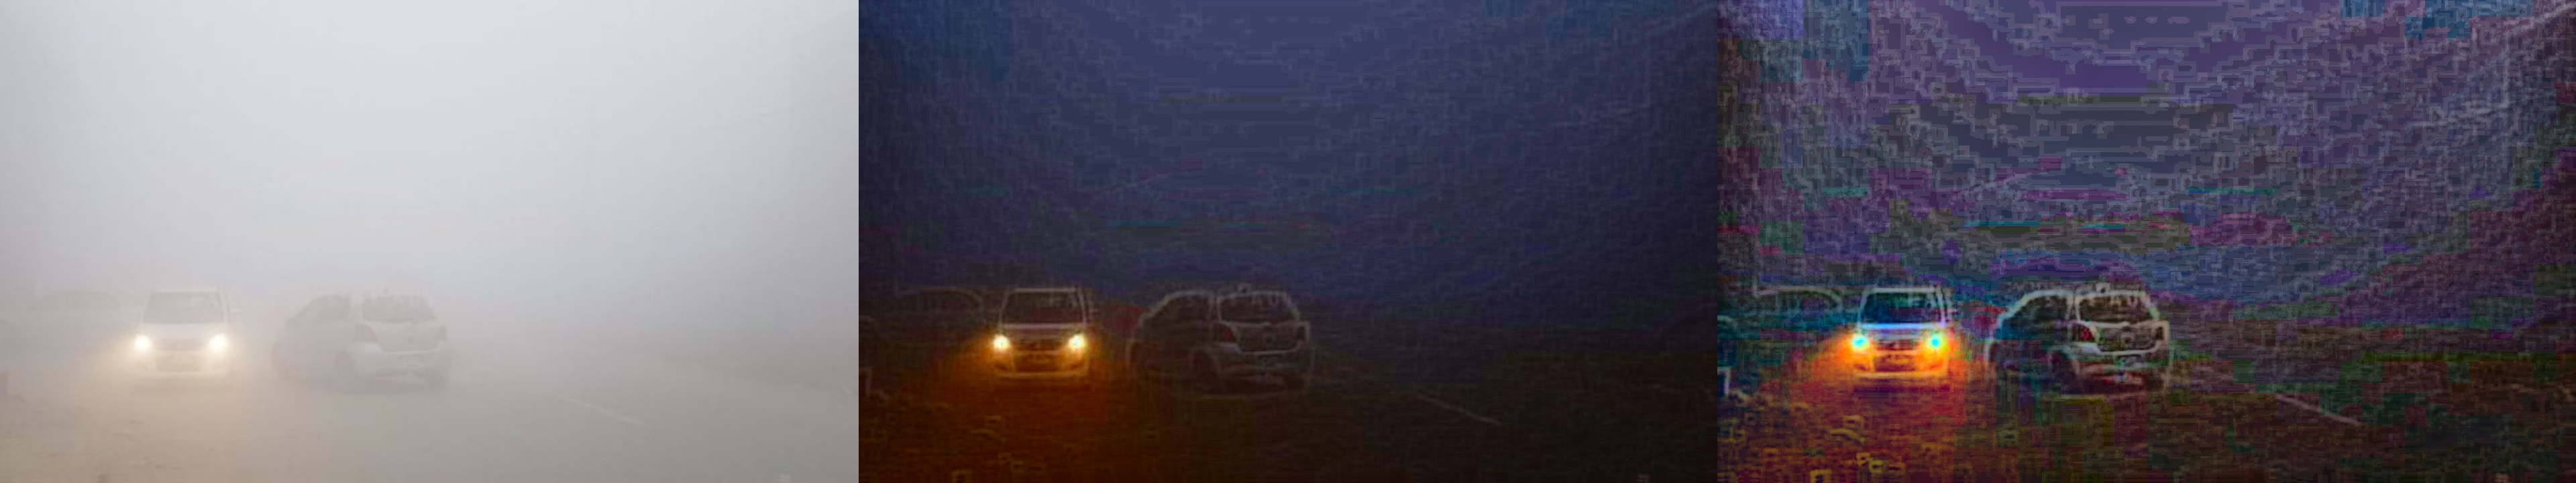

<generator object BasePredictor.stream_inference at 0x7de3a6e0e6c0>


In [ ]:
take_photo()

In [ ]:
%cd {HOME}
y = Image(filename='runs/detect/predict/image0.jpg', height=600)

/content


In [ ]:
# Function for Dark Channel Prior (DCP) defogging
def apply_dcp(image, window_size=15):
    min_channel = cv2.erode(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), np.ones((window_size, window_size), np.uint8))
    num_pixels = int(image.shape[0] * image.shape[1] * 0.001)
    dark_channel_flat = min_channel.reshape(-1)
    indices = dark_channel_flat.argsort()[-num_pixels:]
    atmospheric_light = np.max(image.reshape(-1, 3)[indices], axis=0)
    omega = 0.95
    atmospheric_light = np.array(atmospheric_light, dtype=np.float64)
    transmission = 1 - omega * min_channel / atmospheric_light.max()
    epsilon = 0.001
    scene_radiance = np.zeros_like(image, dtype=np.float64)
    for i in range(3):
        scene_radiance[:, :, i] = ((image[:, :, i].astype(np.float64) - atmospheric_light[i]) / np.maximum(transmission, epsilon)) + atmospheric_light[i]
    scene_radiance = np.uint8(np.clip(scene_radiance, 0, 255))
    return scene_radiance

def detect_objects(image):
     results = model.predict(source=image, stream=True,save=True)
     for r in results:
        boxes = r.boxes
        masks = r.masks
        probs = r.probs
     return results

# Function to apply Histogram Equalization
def apply_hist_eq(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    lab_planes_new = [clahe.apply(plane) for plane in lab_planes]
    lab = cv2.merge(lab_planes_new)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def take_photo(quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')

    display(js)
    try:
        while True:
            # Capture a frame
            # data = eval_js('takePhoto({})'.format(quality))
            # binary = b64decode(data.split(',')[1])

            # Convert the image data to a NumPy array
            # img_array = np.frombuffer(binary, dtype=np.uint8)

            # Decode the NumPy array into an OpenCV image
            # frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
            frame = cv2.imread('/content/mist-971.jpg')
            # Apply Dark Channel Prior (DCP) for defogging
            defogged_frame = apply_dcp(frame)

            # Apply Histogram Equalization to the DCP-processed frame
            enhanced_frame = apply_hist_eq(defogged_frame)
            detected_frame = detect_objects(enhanced_frame)
            # !yolo predict model=yolov8n.pt source=enhanced_buffer

            # Display the original, defogged, and enhanced frames
            _, img_encoded = cv2.imencode('.jpeg', np.hstack([frame, defogged_frame, enhanced_frame]))
            img_bytes = img_encoded.tobytes()
            display(Image(data=img_bytes))
            # %cd {HOME}
            # Image(filename='runs/detect/predict/dog.jpeg', height=600)
            print(detected_frame)
            break
            # Delay for 1 second
            # time.sleep(1)
    except KeyboardInterrupt:
        pass

<IPython.core.display.Javascript object>


0: 384x640 3 cars, 1768.5ms
Speed: 2.6ms preprocess, 1768.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict3


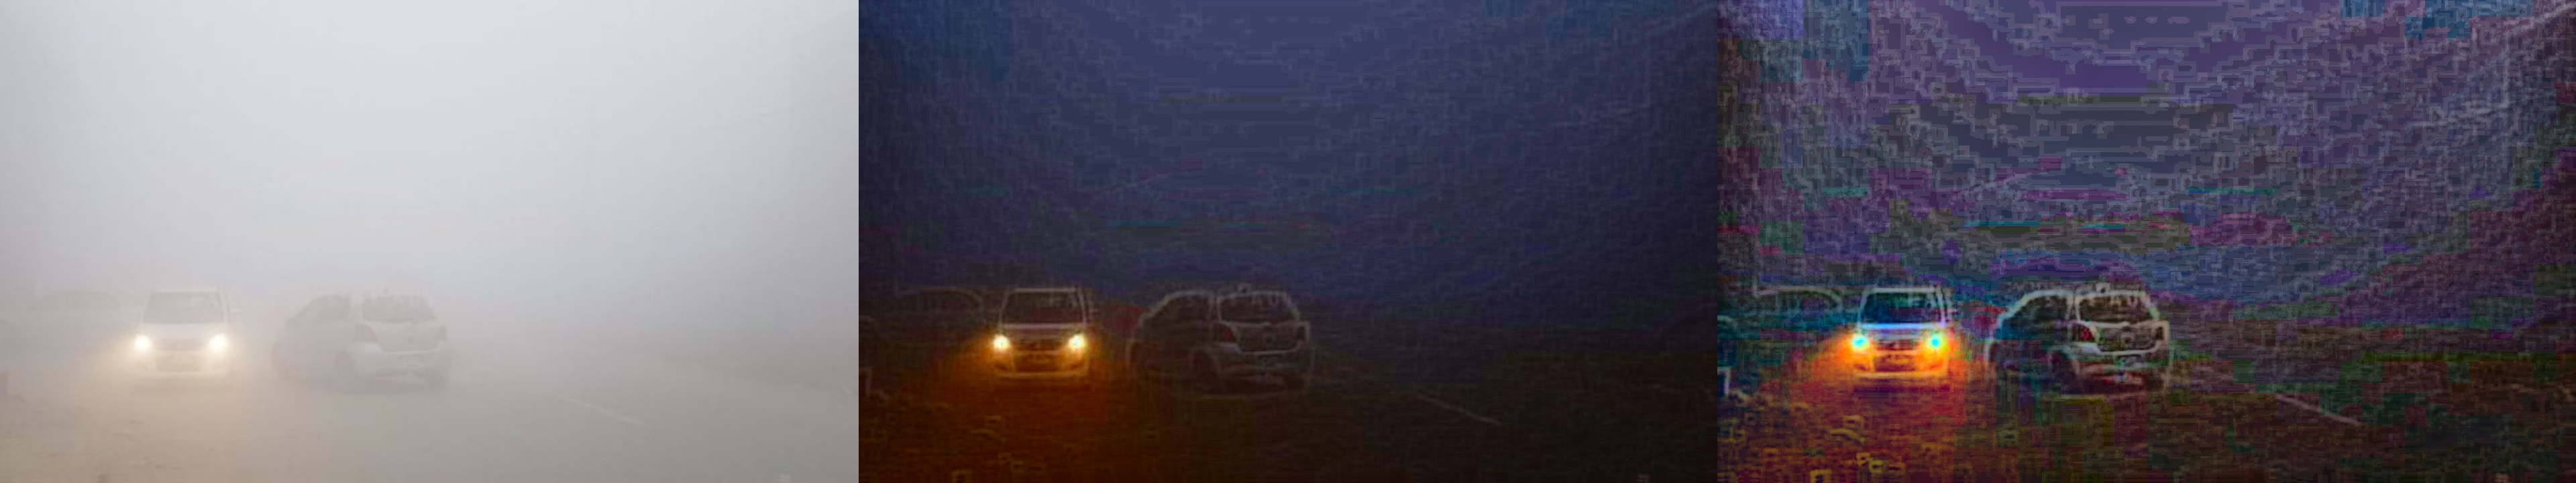

<generator object BasePredictor.stream_inference at 0x7de3a1583a70>


In [ ]:
take_photo()

In [ ]:
%cd {HOME}
y = Image(filename='runs/detect/predict/image0.jpg', height=600)

/content


In [ ]:
from IPython.display import Image

# Replace 'image_link.jpg' with the actual link to your image
image_link = '/content/runs/detect/predict2/image0.jpg'

# Display the image
Image(image_link)


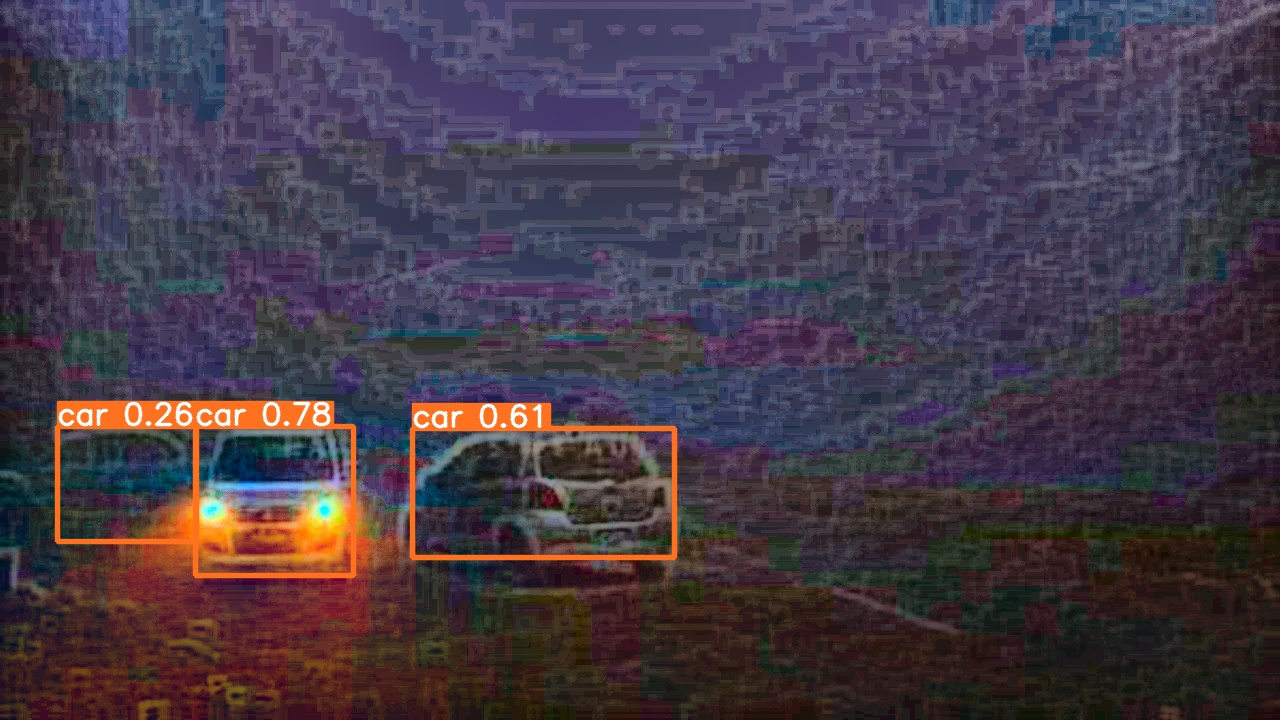

In [ ]:
from IPython.display import Image

# Replace 'image_link.jpg' with the actual link to your image
image_link = '/content/runs/detect/predict2/image0.jpg'

# Display the image
Image(image_link)
